In [1]:
import csv
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# from keras import backend as K
from keras.layers.core import K
# K.clear_session()
# K.set_learning_phase()

Using TensorFlow backend.


In [3]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
K.set_session(sess)

# gpu_usage = ['/gpu:0', '/gpu:1']
gpu_usage = '/gpu:0'

# Dataset 불러오기

udacity dataset과 custom dataset을 모두 사용하는 쪽으로 이용

In [4]:
# set training data version
use_original = False


In [5]:
import sys
print(sys.version)

3.5.2 |Anaconda 4.2.0 (64-bit)| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


In [6]:
def get_dataset(use_original = True):
    if use_original == True:
        csv_filepath = './data/driving_log.csv'
        img_filepath = './data/IMG/'
        splitter = '/'
    else:
        csv_filepath = './data_custom/driving_log.csv'
        img_filepath = './data_custom/IMG/'
        splitter = '\\'

    # parse data
    lines = []
    with open(csv_filepath) as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            lines.append(line)
    
    # get images and measurements from center camera
    images_center = []
    measurements_center = []
    for line in lines:
        source_path = line[0]
        filename = source_path.split(splitter)[-1]
        current_path = img_filepath + filename
        image_ = Image.open(current_path)
        image = np.asarray(image_)
        images_center.append(image)
        measurement = float(line[3])
        measurements_center.append(measurement)


    measurements_center = np.asarray(measurements_center)
    images_center = np.asarray(images_center)

    if use_original == True:
        print('udacity data is loaeded')
    else:
        print('custom data is loaded')
    
    # get images and measurements from left/right camera
    images_lr = []
    measurements_lr = []
    for line in lines:
        for source_path in line[1:3]:
            filename = source_path.split(splitter)[-1]
            current_path = img_filepath + filename
            measurement = float(line[3])

            if measurement != 0:
                if source_path == line[1]:
                    measurement = measurement + 0.23
                else:
                    measurement = measurement - 0.23

                image_ = Image.open(current_path)
                image = np.asarray(image_)
                images_lr.append(image)
                measurements_lr.append(measurement)


    measurements_lr = np.asarray(measurements_lr)
    images_lr = np.asarray(images_lr)

    images = np.concatenate([images_center, images_lr], axis=0)
    measurements = np.concatenate([measurements_center, measurements_lr], axis=0)

    print('data set size: %d' %(len(measurements)))
    
    return images, measurements

In [7]:
# get dataset
images_udacity, measurements_udacity = get_dataset(use_original=True)
images_custom, measurements_custom = get_dataset(use_original=False)

images = np.concatenate([images_udacity, images_custom], axis=0)
measurements = np.concatenate([measurements_udacity, measurements_custom], axis=0)

print('all dataset is loaded.')
print('data set size: %d' %(len(measurements)))

udacity data is loaeded
data set size: 2114
custom data is loaded
data set size: 8152
all dataset is loaded.
data set size: 10266


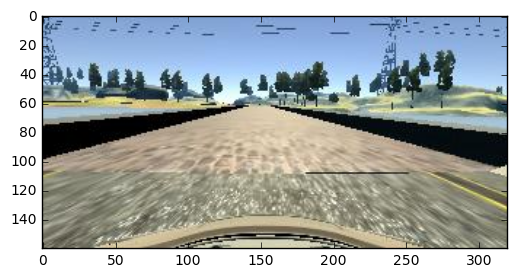

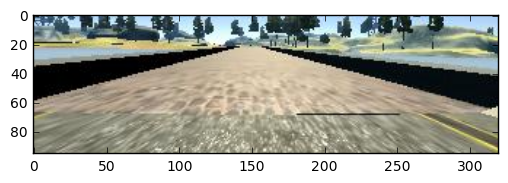

(1, 95, 320, 3)


In [8]:
import random
# show example data
ex_image = images[random.randint(0, len(measurements)),:,:,:]
plt.figure()
plt.imshow(ex_image, cmap='gray')
plt.show()

from keras.models import Sequential
from keras.layers import Cropping2D
from keras.layers.core import Reshape

### crop test
model_crop = Sequential()
model_crop.add(Cropping2D(cropping=((40,25), (0,0)), input_shape=(160,320,3)))

cropping_output = K.function([model_crop.layers[0].input], [model_crop.layers[0].output])
cropped_image = cropping_output([ex_image[None,...]])[0]

plt.imshow(cropped_image[0,...]/255, cmap='gray')
plt.show()
print(cropped_image.shape)

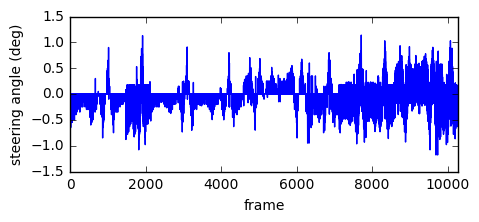

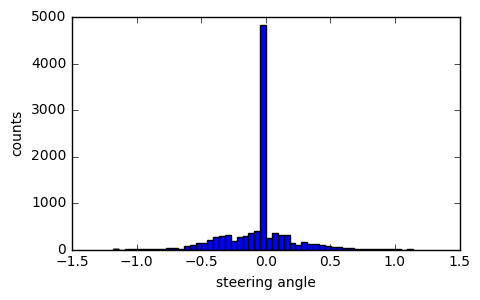

In [8]:
# plot data
plt.figure(figsize=(5,2))
plt.plot(measurements)
plt.xlabel('frame')
plt.ylabel('steering angle (deg)')
plt.xlim([0, len(measurements)])

# plot histogram
plt.figure(figsize=(5,3))
plt.hist(measurements, bins=51)
plt.xlabel('steering angle')
plt.ylabel('counts')

# plot!
plt.show()

# Data Adjustment

데이터가 균일하지 않으니 데이터의 수를 균일하게 맞추는 작업이 필요

In [9]:
# down sampling
import random
zero_images = images[measurements == 0]
zero_measurements = measurements[measurements == 0]

keep_ratio = 0.8
keep_zeros_num = np.floor(len(zero_measurements) * keep_ratio)
keep_zeros_num = keep_zeros_num.astype(int)

zero_ind = [i for i in range(len(zero_measurements))]

random.shuffle(zero_ind)
keep_ind = zero_ind[0:keep_zeros_num]
print(len(keep_ind))

keeped_images = np.concatenate([zero_images[keep_ind], images[measurements != 0]], axis=0)
keeped_measurements = np.concatenate([zero_measurements[keep_ind], measurements[measurements !=0]], axis=0)

print(keeped_images.shape)
print(keeped_measurements.shape)

3669
(9348, 160, 320, 3)
(9348,)


In [10]:
# image augmentation
augmented_images, augmented_measurements = [], []
for image, measurement in zip(keeped_images, keeped_measurements):
    augmented_images.append(image)
    augmented_measurements.append(measurement)
    
    # flip
    if measurement != 0:
        augmented_images.append(np.fliplr(image))
        augmented_measurements.append(-measurement)
    
    # 
    
    
augmented_images = np.asarray(augmented_images)
augmented_measurements = np.asarray(augmented_measurements)

print('augmented data is ready.')
print('augmented data size: ', augmented_images.shape[0])

augmented data is ready.
augmented data size:  15027


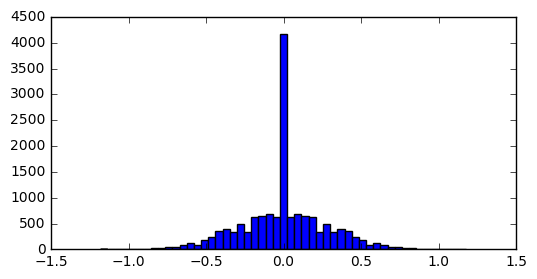

In [11]:
# Histogram of augmented data
plt.figure(figsize=(6,3))
plt.hist(augmented_measurements, bins=51)
plt.show()

In [12]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Activation
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers import Cropping2D
from keras.layers.core import Dropout
from keras.layers.normalization import BatchNormalization

In [13]:
def nvidia_net():
    with K.tf.device(gpu_usage):
        # model setting
        init = 'glorot_normal'
        activation = 'relu'
        keep_prob = 0.5
        keep_prob_dense = 0.7
        
        model = Sequential()
        
        # pre-processing
        model.add(Cropping2D(cropping=((40,25), (0,0)), input_shape=(160,320,3)))
        model.add(Lambda(lambda x: K.tf.image.resize_images(x, (66,200)))) # resize image
        model.add(Lambda(lambda x: x/255.0 -0.5)) # normalization
        
        # Convnet
        model.add(Convolution2D(24,5,5, subsample=(2,2), border_mode='valid', init=init))
        model.add(Activation(activation))
        model.add(Dropout(keep_prob))
        
        model.add(Convolution2D(36,5,5, subsample=(2,2), border_mode='valid', init=init))
        model.add(Activation(activation))
        model.add(Dropout(keep_prob))
        
        model.add(Convolution2D(48,5,5, subsample=(2,2), border_mode='valid', init=init))
        model.add(Activation(activation))
        model.add(Dropout(keep_prob))
        
        model.add(Convolution2D(64,3,3, init=init))
        model.add(Activation(activation))
        model.add(Dropout(keep_prob))
        
        model.add(Convolution2D(64,3,3, init=init))
        model.add(Activation(activation))
        model.add(Dropout(keep_prob))
        
        # FC
        model.add(Flatten())
        model.add(Dense(100, init=init))
        model.add(Dropout(keep_prob_dense))
        model.add(Dense(50, init=init))
        model.add(Dropout(keep_prob_dense))
        model.add(Dense(10, init=init))
        model.add(Dropout(keep_prob_dense))
        model.add(Dense(1, init=init))
        
        # model.summary
        
        return(model)
        

print('nvidia_net is ready.')
model_n = nvidia_net()
model_n.summary()

nvidia_net is ready.
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_1 (Cropping2D)        (None, 95, 320, 3)    0           cropping2d_input_1[0][0]         
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 66, 200, 3)    0           cropping2d_1[0][0]               
____________________________________________________________________________________________________
lambda_2 (Lambda)                (None, 66, 200, 3)    0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 31, 98, 24)    1824        lambda_2[0][0]                   
______________________________________________________________________

In [14]:
def incpt_mod_nvidia_net(gpu_usage = '/gpu:0'):
    with K.tf.device(gpu_usage):
        # model setting
        init = 'glorot_normal'
        activation = 'relu'
        keep_prob_dense = 0.7
        keep_prob = 0.5
        
        model = Sequential()
        
        ### pre-processing
        model.add(Cropping2D(cropping=((40,25), (0,0)), input_shape=(160,320,3)))
        model.add(Lambda(lambda x: K.tf.image.resize_images(x, (66,200)))) # resize image
        model.add(Lambda(lambda x: x/255.0 -0.5)) # normalization
        
        ### Convnet
        model.add(Convolution2D(24,5,5, subsample=(2,2), border_mode='valid', init=init))
        model.add(Activation(activation))
        model.add(Dropout(keep_prob))
        
        # 5x5 convolution factorization
#         model.add(BatchNormalization())
        model.add(Convolution2D(36,3,1, init=init))
        model.add(Convolution2D(36,1,3, init=init))
        model.add(Convolution2D(36,3,3, subsample=(2,2), border_mode='valid', init=init))
        model.add(Activation(activation))
        model.add(Dropout(keep_prob))
        
        # 5x5 factorfization
#         model.add(BatchNormalization())
        model.add(Convolution2D(48,3,1, init=init))
        model.add(Convolution2D(48,1,3, init=init))
        model.add(Convolution2D(48,3,3, subsample=(2,2), border_mode='valid', init=init))
        model.add(Activation(activation))
        model.add(Dropout(keep_prob))

        
        # 3x3 factorization
#         model.add(BatchNormalization())
        model.add(Convolution2D(48,3,1, init=init))
        model.add(Convolution2D(64,1,3, init=init))
        model.add(Activation(activation))
        model.add(Dropout(keep_prob))

        # 3x3 factorization
#         model.add(BatchNormalization())
        model.add(Convolution2D(48,3,1, init=init))
        model.add(Convolution2D(64,1,3, init=init))
        model.add(Activation(activation))
        model.add(Dropout(keep_prob))
        
        # average pooling
        model.add(AveragePooling2D(pool_size=(1,6)))
        
        # FC
        model.add(Flatten())
        model.add(Dense(100, init=init))
        model.add(Dropout(keep_prob_dense))
        model.add(Dense(50, init=init))
        model.add(Dropout(keep_prob_dense))
        model.add(Dense(10, init=init))
        model.add(Dropout(keep_prob_dense))
        model.add(Dense(1, init=init))
        
        # model.summary
        
        return(model)
        

print('incpt_mod_nvidia_net is ready.')
model_nm = incpt_mod_nvidia_net()
model_nm.summary()

incpt_mod_nvidia_net is ready.
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_2 (Cropping2D)        (None, 95, 320, 3)    0           cropping2d_input_2[0][0]         
____________________________________________________________________________________________________
lambda_3 (Lambda)                (None, 66, 200, 3)    0           cropping2d_2[0][0]               
____________________________________________________________________________________________________
lambda_4 (Lambda)                (None, 66, 200, 3)    0           lambda_3[0][0]                   
____________________________________________________________________________________________________
convolution2d_6 (Convolution2D)  (None, 31, 98, 24)    1824        lambda_4[0][0]                   
____________________________________________________________

# Training/Loading

네트워크 최적화 / 기존 네트워크 불러오기

In [15]:
nb_epoch = 1000
batch_size = 1024
do_train = True

In [16]:
from keras.models import Model, load_model
from keras.optimizers import Adagrad
from keras.callbacks import EarlyStopping, ModelCheckpoint

earlyStopping = EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')

validation_split = 0.2
if do_train == True:
    with K.tf.device(gpu_usage):
#         model = incpt_mod_nvidia_net(gpu_usage)
        model = nvidia_net()
        adagrad = Adagrad(lr=0.005, epsilon=1e-08, decay=0.0)
#         model.compile(loss='mse', optimizer=adagrad)
        model.compile(loss='mse', optimizer='Adagrad')

        history_object = model.fit(
            np.array(augmented_images), np.array(augmented_measurements), 
            nb_epoch=nb_epoch, validation_split=validation_split, 
            shuffle=True, batch_size=batch_size)

        model.save('model_origin.h5')
else:
    model = load_model('./model.h5')

Train on 12021 samples, validate on 3006 samples
Epoch 1/1000
12021/12021 [==============================] - 77s - loss: 0.1051 - val_loss: 0.1344
Epoch 2/1000
12021/12021 [==============================] - 8s - loss: 0.0645 - val_loss: 0.1

dict_keys(['val_loss', 'loss'])
dict_keys(['val_loss', 'loss'])


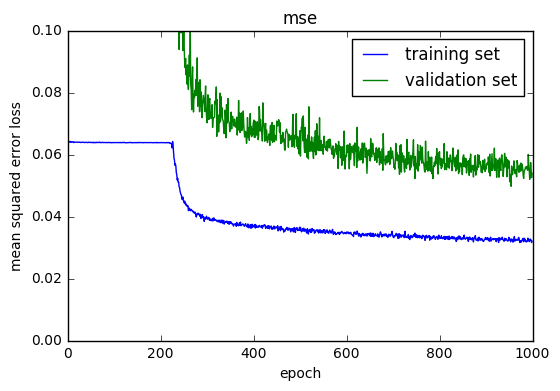

In [17]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
history_ = history_object.history
print(history_.keys())
np.save('history_obj_origin.npy', history_)

plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('mse')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.ylim([0, 0.1])
plt.show()

In [ ]:
K.clear_session()